In [16]:
# visualization settings
import seaborn as sns
import pandas as pd

sns.set_context("talk")
sns.set_style("ticks")
sns.set_palette("colorblind")

In [2]:
df_peng = sns.load_dataset("penguins")
df_peng = df_peng.dropna().reset_index(drop=True)    # 결측치 제거 후 index reset
df_peng.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
3,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female
4,Adelie,Torgersen,39.3,20.6,190.0,3650.0,Male


In [3]:
from sklearn.model_selection import train_test_split

y = df_peng["body_mass_g"]
X = df_peng.drop("body_mass_g", axis=1)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, 
                                                  stratify=X[["species", "island", "sex"]])

# Pipeline

In [4]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

def get_model(method="rf",
              cat_features=["species", "island", "sex"], 
              num_features=["bill_length_mm", "bill_depth_mm", "flipper_length_mm"],
              **kwargs):
    # 1-1.categorical feature에 one-hot encoding 적용
    cat_transformer = OneHotEncoder()

    # 1-2.numerical feature는 standard scaler 적용
    num_transformer = StandardScaler()

    # 2. 인자 종류별 전처리 적용
    preprocessor = ColumnTransformer([("cat", cat_transformer, cat_features), 
                                    ("num", num_transformer, num_features)])

    # 3. 전처리 후 입력된 방법론 적용
    if method == "rf":
        ml = ("ml", RandomForestRegressor(**kwargs))
    elif method == "lgbm":
        ml = ("ml", LGBMRegressor(**kwargs))
    elif method == "xgb":
        ml = ("ml", XGBRegressor(**kwargs))

    pipeline = Pipeline(steps=[("preprocessor", preprocessor), 
                               ml])
    
    return pipeline

In [5]:
from sklearn import set_config
set_config(display='diagram')

In [6]:
from sklearn.ensemble import RandomForestRegressor

model = get_model(method="rf")

In [7]:
model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat', OneHotEncoder(),
                                                  ['species', 'island', 'sex']),
                                                 ('num', StandardScaler(),
                                                  ['bill_length_mm',
                                                   'bill_depth_mm',
                                                   'flipper_length_mm'])])),
                ('ml', RandomForestRegressor())])

# Decision Tree Visualizer

In [8]:
import io
import pydot
from IPython.core.display import Image
from sklearn.tree import export_graphviz


def draw_decision_tree(model, 
                       feature_names=["bill_length_mm", "bill_depth_mm", "flipper_length_mm",
                                      "species_Adelie", "species_Chinstrap", "species_Gentoo", 
                                      "island_Biscoe", "island_Dream", "island_Torgersen", 
                                      "sex_Female", "sex_Male"]):
    dot_buf = io.StringIO()
    export_graphviz(model, out_file=dot_buf, feature_names=feature_names)
    graph = pydot.graph_from_dot_data(dot_buf.getvalue())[0]
    image = graph.create_png()
    return Image(image)

In [9]:
dts = model["ml"].estimators_
print(len(dts))
draw_decision_tree(dts[2])

100


FileNotFoundError: [WinError 2] "dot" not found in path.

In [10]:
model["ml"].get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

# Visualization code: parity plot

In [11]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

c_train = "g"
c_val = "m"

def get_parity(y_train, y_val, y_pred_train, y_pred_val):
    fig, axs = plt.subplots(ncols=2, figsize=(10, 5.5), constrained_layout=True, sharex=True, sharey=True)
    for ax, y_true, y_pred, c, title in zip(axs, [y_train, y_val], [y_pred_train, y_pred_val], [c_train, c_val], ["train", "valid"]):
        ax.scatter(y_true, y_pred, c=c)
        ax.set_xlabel("true", color="gray", labelpad=12)
        if ax == axs[0]:
            ax.set_ylabel("prediction", color="gray", labelpad=12)
        ax.set_title(title, color="gray", pad=12)

        r2 = r2_score(y_true, y_pred)
        rmse = mean_squared_error(y_true, y_pred, squared=False)

        xmin, xmax = ax.get_xlim()
        ymin, ymax = ax.get_ylim()
        limmin = min(xmin, ymin)
        limmax = max(xmax, ymax)
        ax.plot([limmin, limmax], [limmin, limmax], c="k", alpha=0.5)
        ax.set_xlim(limmin, limmax)
        ax.set_ylim(limmin, limmax)

        ax.text(0.95, 0.05, f"R2 = {r2:.3f}\nRMSE = {rmse:.3f}", ha="right", transform=ax.transAxes, fontsize=16)
    return fig

# Test Run

In [12]:
import time

def timelog(fn):
    def wrap_fn(*args, **kwargs):
        time_start = time.time()
        result = fn(*args, **kwargs)
        time_end = time.time()
        print(f"# running time: {time_end-time_start:.2f} sec.")
        return result
    return wrap_fn

@timelog
def fit_pipeline(model, X_train, y_train):
    model.fit(X_train, y_train)
    return model

# running time: 0.08 sec.


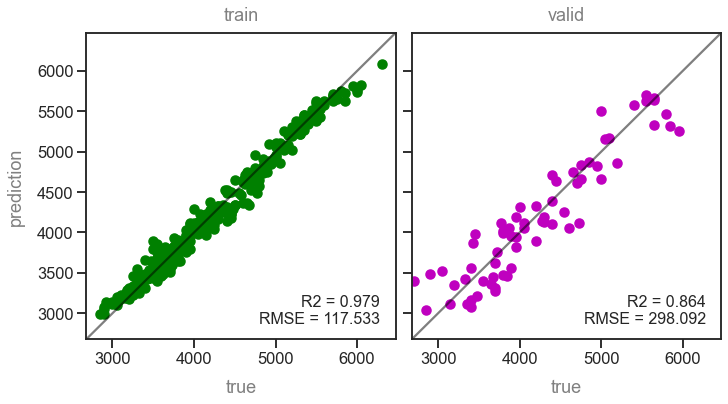

In [13]:
import time

# model 생성
model_default = get_model(method="rf", random_state=0)

# model 학습 & 학습 시간 측정
time_start = time.time()
model = model_default.fit(X_train, y_train)
time_end = time.time()
print(f"# running time: {time_end-time_start:.2f} sec.")

# model 예측
y_pred_train = model_default.predict(X_train)
y_pred_val = model_default.predict(X_val)

fig = get_parity(y_train, y_val, y_pred_train, y_pred_val)

## Grid search
- 시간이 오래걸리는 단점
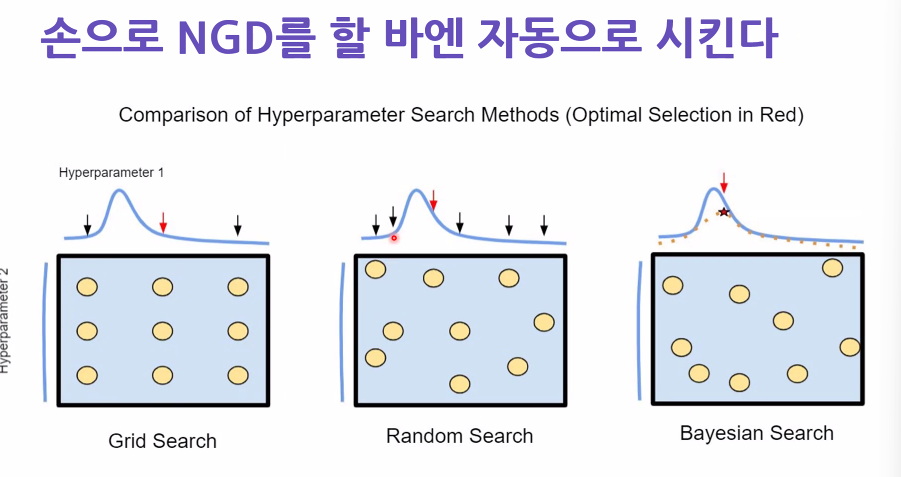

In [ ]:
from sklearn.model_selection import GridSearchCV

# parameter grid
params = {"ml__n_estimators": [100, 200, 300],
          "ml__max_depth": [3, 5, 10],
          "ml__min_samples_leaf": [1, 3, 5, 7, 10],
          "ml__max_features": ["auto", "sqrt", "log2"]}


model = get_model(method="rf", random_state=0)
gscv = GridSearchCV(model, param_grid=params, scoring="r2", refit="r2")

# GridSearchCV 학습 & 학습 시간 측정
time_start = time.time()
gscv.fit(X_train, y_train)
time_end = time.time()
print(f"# running time: {time_end-time_start:.2f} sec.")

gscv

In [ ]:


pd.DataFrame.from_dict(gscv.cv_results_)

In [ ]:
# best hyperparameters
print(gscv.best_params_)

# best score
print(gscv.best_score_)

In [ ]:
y_pred_train = gscv.predict(X_train)
y_pred_val = gscv.predict(X_val)
fig = get_parity(y_train, y_val, y_pred_train, y_pred_val)

## (2) Random Search CV
- 많은 파라미터 중에서 최대 뽑는개수 제한
- 재현성 보장이 안됨

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
import scipy.stats as stats

# parameter distribution
params = {"ml__n_estimators": stats.randint(100, 300),   # [100, 200, 300]
          "ml__max_depth": stats.randint(3, 10),         # [3, 5, 10],
          "ml__min_samples_leaf": stats.randint(1, 10),  # [1, 3, 5, 7, 10]
          "ml__max_features": stats.uniform(0, 1),       # ["auto", "sqrt", "log2"]
          }

# RandomizedSearchCV Pipeline 생성
model = get_model(method="rf", random_state=0)
rscv = RandomizedSearchCV(model, param_distributions=params, # param_grid
                          n_iter=30,                         # number of HP sampling
                          scoring="r2", refit="r2") # n_iter: 최대 뽑는개수 

# RandomizedSearchCV 학습 & 학습 시간 측정
time_start = time.time()
rscv.fit(X_train, y_train)
time_end = time.time()
print(f"# running time: {time_end-time_start:.2f} sec.")

In [ ]:
pd.DataFrame.from_dict(rscv.cv_results_)

In [ ]:
# best hyperparameters
print(rscv.best_params_)

# best score
print(rscv.best_score_)

In [ ]:
y_pred_train = rscv.predict(X_train)
y_pred_val = rscv.predict(X_val)
fig = get_parity(y_train, y_val, y_pred_train, y_pred_val)

## Bayes Search CV
- scikit-optimizer 추천: 문서화가 잘되어있음
- 하이퍼파라미터 하나뽑고 분위기 보고 뽑음
 : 계산속도 GridSearchCV보단 빠르나 Random보단 뽑음
- 6개의 라이브러리 성능은 비슷 
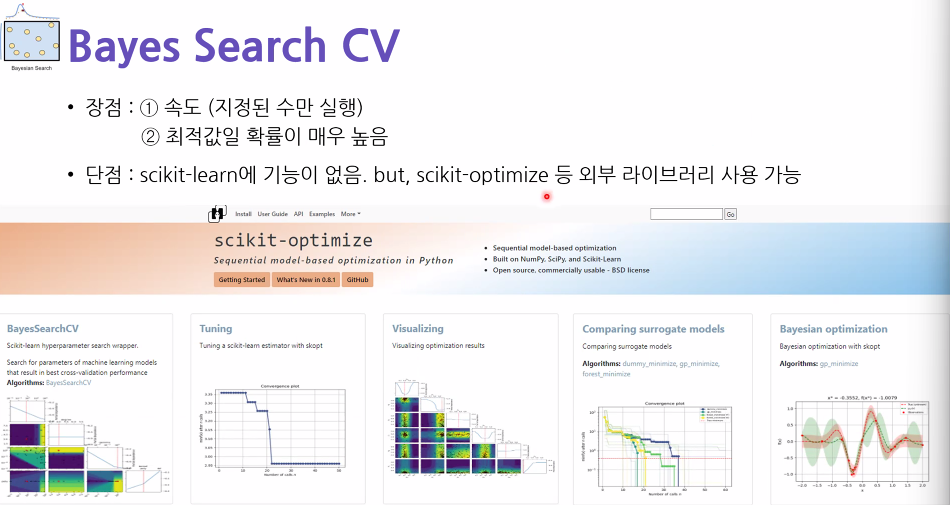

In [23]:
from skopt import BayesSearchCV
from skopt.space import Categorical, Integer

# parameter distribution
params = {"ml__n_estimators": Integer(100, 300),        # [100, 200, 300]
          "ml__max_depth": Integer(3, 10),              # [3, 5, 10],
          "ml__min_samples_leaf": Integer(1, 10),       # [1, 3, 5, 7, 10]
          "ml__max_features": Categorical(["auto", "sqrt", "log2"]) # ["auto", "sqrt", "log2"]
          }

# BayesSearchCV Pipeline 생성
model = get_model(method="rf", random_state=0)
bscv = BayesSearchCV(model, search_spaces=params,  # param_grid
                     n_iter=30,                    # number of HP sampling
                     cv=5,                         # number of folds in CV 
                     scoring="r2", refit="r2")

# BayesSearchCV 학습 & 학습 시간 측정
time_start = time.time()
bscv.fit(X_train, y_train)
time_end = time.time()
print(f"# running time: {time_end-time_start:.2f} sec.")

# running time: 32.66 sec.


In [18]:
pd.DataFrame.from_dict(bscv.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_ml__max_depth,param_ml__max_features,param_ml__min_samples_leaf,param_ml__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.127423,0.001167,0.011002,3.873843e-07,4,log2,8,236,"{'ml__max_depth': 4, 'ml__max_features': 'log2...",0.852633,0.824176,0.876933,0.843550,0.872270,0.853912,0.019288,24
1,0.111427,0.001856,0.009402,8.004907e-04,4,auto,7,187,"{'ml__max_depth': 4, 'ml__max_features': 'auto...",0.865968,0.846477,0.874494,0.833767,0.880294,0.860200,0.017484,12
2,0.103732,0.001600,0.009402,4.900182e-04,4,sqrt,9,194,"{'ml__max_depth': 4, 'ml__max_features': 'sqrt...",0.848819,0.823546,0.874422,0.842440,0.873299,0.852505,0.019320,26
3,0.088620,0.001497,0.007602,4.900965e-04,8,auto,5,144,"{'ml__max_depth': 8, 'ml__max_features': 'auto...",0.865938,0.846478,0.878760,0.830816,0.883464,0.861091,0.019831,9
4,0.070416,0.001019,0.006802,4.000903e-04,7,log2,5,127,"{'ml__max_depth': 7, 'ml__max_features': 'log2...",0.860856,0.835102,0.879851,0.839064,0.882077,0.859390,0.019690,16
5,0.109801,0.001674,0.009203,3.995207e-04,9,auto,3,172,"{'ml__max_depth': 9, 'ml__max_features': 'auto...",0.868043,0.843923,0.878879,0.824857,0.881116,0.859364,0.021718,17
6,0.122219,0.001459,0.010203,4.001379e-04,8,auto,5,201,"{'ml__max_depth': 8, 'ml__max_features': 'auto...",0.867297,0.845011,0.879840,0.830881,0.881896,0.860985,0.019970,10
7,0.094821,0.001470,0.008802,4.001619e-04,6,log2,6,173,"{'ml__max_depth': 6, 'ml__max_features': 'log2...",0.858823,0.828643,0.879271,0.843933,0.879243,0.857982,0.019820,19
8,0.076617,0.000800,0.007202,4.001858e-04,9,log2,8,137,"{'ml__max_depth': 9, 'ml__max_features': 'log2...",0.850245,0.832633,0.876269,0.841885,0.876775,0.855561,0.017999,23
9,0.073816,0.001166,0.007202,4.003049e-04,9,log2,3,130,"{'ml__max_depth': 9, 'ml__max_features': 'log2...",0.865603,0.832467,0.887650,0.838561,0.886675,0.862191,0.023243,7


In [19]:
# best hyperparameters
print(bscv.best_params_)

# best score
print(bscv.best_score_)

OrderedDict([('ml__max_depth', 5), ('ml__max_features', 'sqrt'), ('ml__min_samples_leaf', 1), ('ml__n_estimators', 102)])
0.8649041290593601


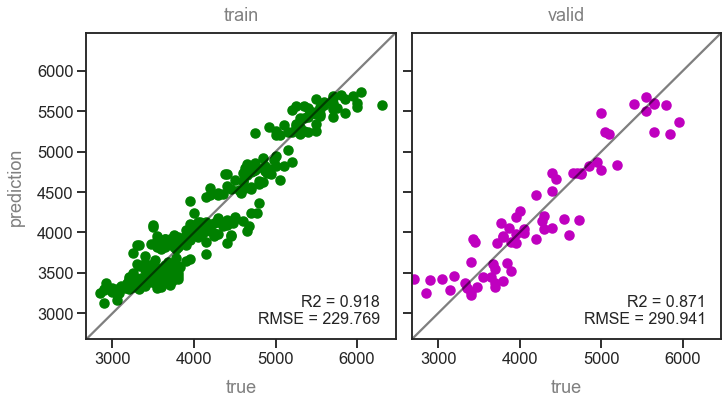

In [20]:
y_pred_train = bscv.predict(X_train)
y_pred_val = bscv.predict(X_val)
fig = get_parity(y_train, y_val, y_pred_train, y_pred_val)

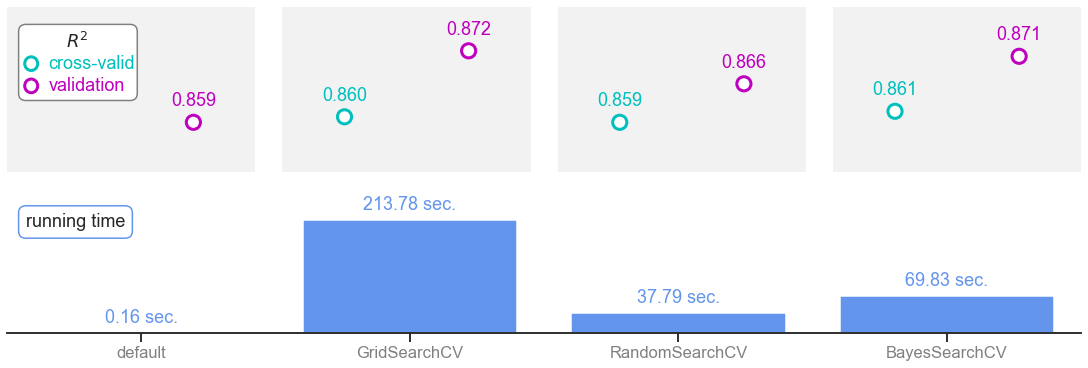

In [21]:
from matplotlib.patches import Ellipse

fig = plt.Figure(figsize=(15, 5), constrained_layout=True)
sfigs = fig.subfigures(nrows=2, hspace=0.1)

axs_R2 = sfigs[0].subplots(ncols=4, sharex=True, sharey=True, gridspec_kw={"wspace":0.1})
R2_cvs = [-1, 0.860, 0.859, 0.861]
R2_vals = [0.859, 0.872, 0.866, 0.871]

for ax, R2_cv, R2_val in zip(axs_R2, R2_cvs, R2_vals):
    ax.scatter([0, 1], [R2_cv, R2_val], fc="w", ec=["c", "m"], lw=3, s=200)
    if ax in axs_R2[1:]:
        ax.text(0, R2_cv+0.003, f"{R2_cv:.3f}", ha="center", color="c")
    ax.text(1, R2_val+0.003, f"{R2_val:.3f}", ha="center", color="m")
    ax.set(xlim=(-0.5, 1.5), ylim=(0.85, 0.88), xticks=[], yticks=[])
    # ax.set_xticklabels(["CV", "valid set"], color="gray")
    ax.spines[:].set_visible(False)
    # ax.spines["bottom"].set_visible(True)
    ax.set_fc("0.95")

sfigs[0].text(0.02, 0.5, "        $R^2$         \n\n", transform=sfigs[0].transSubfigure, 
           bbox={"boxstyle":"round", "fc":"w", "ec":"gray", "pad":0.4})
marker0 = Ellipse((0.025, 0.65), 0.012, 0.08, ec="c", fc="w", lw=3, zorder=10)
marker1 = Ellipse((0.025, 0.52), 0.012, 0.08, ec="m", fc="w", lw=3, zorder=10)
sfigs[0].add_artist(marker0)
sfigs[0].add_artist(marker1)
sfigs[0].text(0.041, 0.62, "cross-valid", color="c", transform=sfigs[0].transSubfigure)
sfigs[0].text(0.041, 0.49, "validation", color="m", transform=sfigs[0].transSubfigure)


ts = [0.16, 213.78, 37.79, 69.83]
axs_t = sfigs[1].subplots()
axs_t.bar([0, 1, 2, 3], ts, color="cornflowerblue")
axs_t.set(xlim=(-0.5, 3.5), xticks=[0, 1, 2, 3], yticks=[])
axs_t.set_xticklabels(["default", "GridSearchCV", "RandomSearchCV", "BayesSearchCV"], color="gray")
for p in axs_t.patches:
    h = p.get_height()
    x = p.get_x()
    w = p.get_width()
    axs_t.text(x+w/2, h+20, f"{h} sec.", color="cornflowerblue", ha="center")
axs_t.spines[:].set_visible(False)
axs_t.spines["bottom"].set_visible(True)
sfigs[1].text(0.02, 0.8, "running time", transform=sfigs[1].transSubfigure, 
           bbox={"boxstyle":"round", "fc":"w", "ec":"cornflowerblue", "pad":0.4})

display(fig)